# <span style="color:#458dc8"> U-NET <span>
### Biblioteki

In [5]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from torch.utils.data import DataLoader, Dataset
import random
import cv2

# <span style="color:#458dc8"> Pobieranie oraz przygotowywanie danych <span>

Example nr 1: 
Input: 


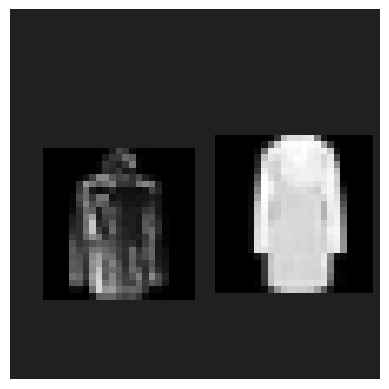

Mask 1: 


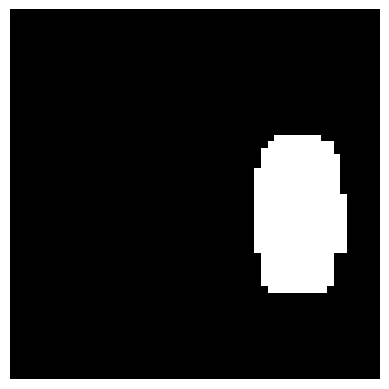

Mask 2: 


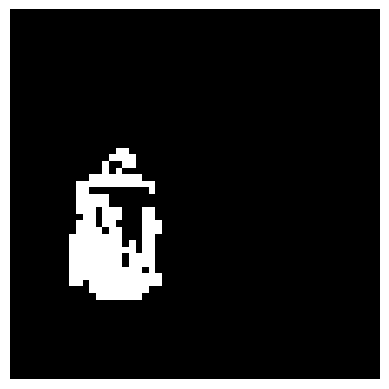

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# ustawienia
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1, lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.', '..', 'data'), train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

def create_samples_with_two_objects(train_loader, num_samples=1000):
    samples = []
    dataset_len = len(train_loader.dataset)
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(dataset_len, 2, replace=False)
        img1, _ = train_loader.dataset[idx1]
        img2, _ = train_loader.dataset[idx2]


        scale1 = np.random.uniform(0.7, 1.7)
        scale2 = np.random.uniform(0.7, 1.7)
        img1 = transforms.Resize(int(28 * scale1))(img1)
        img2 = transforms.Resize(int(28 * scale2))(img2)


        for attempt in range(50):
            x1, y1 = np.random.randint(0, 56 - img1.shape[1]), np.random.randint(0, 56 - img1.shape[2])
            x2, y2 = np.random.randint(0, 56 - img2.shape[1]), np.random.randint(0, 56 - img2.shape[2])
            if (x1 + img1.shape[1] < x2 or x2 + img2.shape[1] < x1) or (y1 + img1.shape[2] < y2 or y2 + img2.shape[2] < y1):
                background[:, y1:y1+img1.shape[1], x1:x1+img1.shape[2]] = img1
                background[:, y2:y2+img2.shape[1], x2:x2+img2.shape[2]] = img2
                mask1 = torch.zeros_like(background)
                mask2 = torch.zeros_like(background)
                mask1[:, y1:y1+img1.shape[1], x1:x1+img1.shape[2]] = (img1 > 0.15).float()
                mask2[:, y2:y2+img2.shape[1], x2:x2+img2.shape[2]] = (img2 > 0.15).float()
                samples.append((background, mask1, mask2))
                break
    return samples

def colorize_masks(samples):
    colorized_samples = []
    for background, mask1, mask2 in samples:
        mask1_bw = (mask1.squeeze() > 0).float()
        mask2_bw = (mask2.squeeze() > 0).float()
        mask1_bw = mask1_bw.unsqueeze(0)
        mask2_bw = mask2_bw.unsqueeze(0) 
        colorized_samples.append((background, mask1_bw, mask2_bw))
    return colorized_samples

# Tworzenie próbek
n = 30000
samples = create_samples_with_two_objects(train_loader, n)
colorized_samples = colorize_masks(samples)

# Wyświetlanie próbek
for i in range(1):
    img, mask1, mask2 = colorized_samples[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Mask 1: ")
    plt.imshow(mask1.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Mask 2: ")
    plt.imshow(mask2.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

img, mask1

In [7]:
img, mask1, mask2 = colorized_samples[0]

print(f"colorized_samples type: {type(colorized_samples)}, length: number of colorized_samples")
print(f"colorized_samples[0] type: {type(colorized_samples[0])}, length: {len(colorized_samples[0])}")
print(f"Image type: {type(img)}, shape: {img.shape}")
print(f"Mask1 type: {type(mask1)}, shape: {mask1.shape}")
print(f"Mask2 type: {type(mask2)}, shape: {mask2.shape}")

colorized_samples type: <class 'list'>, length: number of colorized_samples
colorized_samples[0] type: <class 'tuple'>, length: 3
Image type: <class 'torch.Tensor'>, shape: torch.Size([1, 56, 56])
Mask1 type: <class 'torch.Tensor'>, shape: torch.Size([1, 56, 56])
Mask2 type: <class 'torch.Tensor'>, shape: torch.Size([1, 56, 56])


# <span style="color:#458dc8"> Model <span>

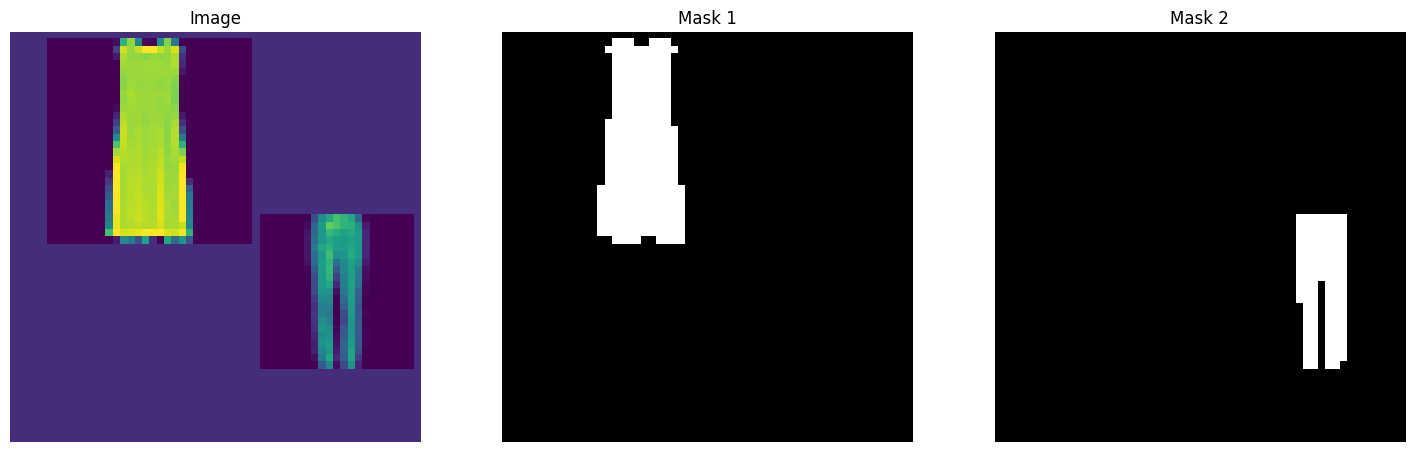

Dataset length: 4088
Number of batches: 64


In [8]:
class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, mask1, mask2 = self.samples[idx]
        combined_mask = torch.cat((mask1, mask2), dim=0)  
        return image, combined_mask

custom_dataset = CustomDataset(colorized_samples)
train_loader = DataLoader(custom_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)

def display_sample(data_loader):
    images, masks = next(iter(data_loader))
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    axs[0].imshow(images[0].permute(1, 2, 0))
    axs[0].set_title("Image")
    axs[1].imshow(masks[0][0].squeeze(), cmap='gray')
    axs[1].set_title("Mask 1")
    axs[2].imshow(masks[0][1].squeeze(), cmap='gray')
    axs[2].set_title("Mask 2")

    for ax in axs:
        ax.axis('off')
    plt.show()

display_sample(train_loader)

print(f"Dataset length: {len(train_loader.dataset)}")
print(f"Number of batches: {len(train_loader)}")



In [271]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

args = SimpleNamespace(batch_size=8, test_batch_size=1000, epochs=5,
                       lr=0.001, momentum=0.5, seed=1, log_interval=1)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


# U-NET
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mid = self.middle(enc)
        dec = self.decoder(mid)
        return dec

model = UNet(in_channels=1, out_channels=2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


# trenowanie
for epoch in range(1, args.epochs + 1):
    print(f"Starting epoch {epoch}")
    train(model, device, train_loader, optimizer, epoch)
torch.save(model.state_dict(), 'unet_model.pth')


Starting epoch 1
Train Epoch: 1 [0/3983 (0%)]	Loss: 0.695389
Train Epoch: 1 [64/3983 (2%)]	Loss: 0.686740
Train Epoch: 1 [128/3983 (3%)]	Loss: 0.671679
Train Epoch: 1 [192/3983 (5%)]	Loss: 0.639334
Train Epoch: 1 [256/3983 (6%)]	Loss: 0.577453
Train Epoch: 1 [320/3983 (8%)]	Loss: 0.512172
Train Epoch: 1 [384/3983 (10%)]	Loss: 0.475082
Train Epoch: 1 [448/3983 (11%)]	Loss: 0.446334
Train Epoch: 1 [512/3983 (13%)]	Loss: 0.375651
Train Epoch: 1 [576/3983 (14%)]	Loss: 0.320716
Train Epoch: 1 [640/3983 (16%)]	Loss: 0.290834
Train Epoch: 1 [704/3983 (17%)]	Loss: 0.265650
Train Epoch: 1 [768/3983 (19%)]	Loss: 0.239924
Train Epoch: 1 [832/3983 (21%)]	Loss: 0.229785
Train Epoch: 1 [896/3983 (22%)]	Loss: 0.233147
Train Epoch: 1 [960/3983 (24%)]	Loss: 0.226992
Train Epoch: 1 [1024/3983 (25%)]	Loss: 0.216552
Train Epoch: 1 [1088/3983 (27%)]	Loss: 0.207109
Train Epoch: 1 [1152/3983 (29%)]	Loss: 0.199184
Train Epoch: 1 [1216/3983 (30%)]	Loss: 0.201502
Train Epoch: 1 [1280/3983 (32%)]	Loss: 0.183542


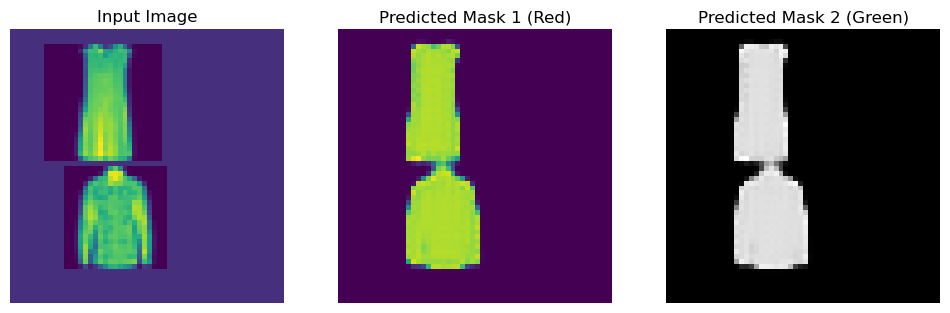

In [272]:
def predict(img, model):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)

        mask1_final = torch.sigmoid(output[0, 0]).cpu().numpy()
        mask2_final = torch.sigmoid(output[0, 1]).cpu().numpy()

        return mask1_final, mask2_final

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=2).to(device)

model.load_state_dict(torch.load('unet_model.pth', map_location=device))

dataset = CustomDataset(colorized_samples)
test_img, _ = dataset[0]  # Przykładzik

mask1_pred, mask2_pred = predict(test_img, model)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_img.permute(1, 2, 0).cpu())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask 1 (Red)")
plt.imshow(mask1_pred)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask 2 (Green)")
plt.imshow(mask2_pred, cmap='gray')
plt.axis('off')

plt.show()

(-0.5, 55.5, 55.5, -0.5)

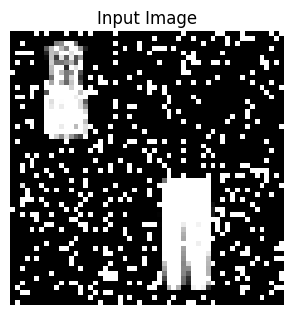

In [26]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.', '..', 'data'), train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

samples_test = create_samples_with_two_objects(train_loader, 50)
colorized_samples_test = colorize_masks(samples_test)

dataset = CustomDataset(colorized_samples_test)
test_img, _ = dataset[2]  

def add_noise_to_image(image, noise_level=0.1, num_noisy_pixels=500):
    noisy_image = image.clone()
    c, h, w = noisy_image.shape
    total_pixels = h * w
    random_indices = torch.randperm(total_pixels)[:num_noisy_pixels]
    noise = torch.rand(num_noisy_pixels) * noise_level
    noisy_image.view(-1)[random_indices] += noise
    return noisy_image.clamp(0, 1)

num_noisy_pixels = 500  # Możliwość ustawienia liczby losowych pikseli z szumami
noisy_test_img = add_noise_to_image(test_img, num_noisy_pixels)

mask1_pred, mask2_pred = predict(noisy_test_img, model)

# Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(noisy_test_img.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask 1 (Red)")
plt.imshow(mask1_pred, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask 2 (Green)")
plt.imshow(mask2_pred, cmap='gray')
plt.axis('off')

plt.show()

print(f"Mask2 type: {type(mask1_pred)}, shape: {mask1_pred.shape}")

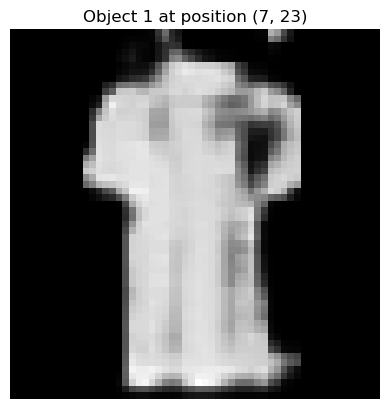

Object 1 saved at object_1.png with position (7, 23)


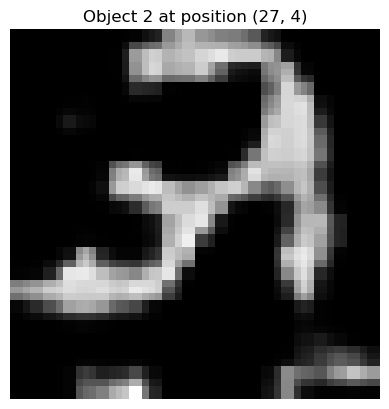

Object 2 saved at object_2.png with position (27, 4)


In [274]:
def extract_objects_from_image(image):
    if image.dtype != np.uint8:
        image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)
    
    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_image, connectivity=8)

    component_sizes = stats[1:, cv2.CC_STAT_AREA]
    bounding_boxes = stats[1:, :4]

    if len(component_sizes) < 2:
        raise ValueError("Not enough objects found")
    largest_indices = component_sizes.argsort()[-2:][::-1]

    objects = []
    for i in largest_indices:
        x, y, w, h = bounding_boxes[i]
        obj_image = image[y:y+h, x:x+w]

        aspect_ratio = w / h
        if aspect_ratio > 1:
            new_w = 56
            new_h = int(56 / aspect_ratio)
        else:
            new_h = 56
            new_w = int(56 * aspect_ratio)

        obj_image_resized = cv2.resize(obj_image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        canvas = np.zeros((56, 56), dtype=np.uint8)
        x_offset = (56 - new_w) // 2
        y_offset = (56 - new_h) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = obj_image_resized
        
        objects.append((canvas, (x, y)))
    
    return objects

image = mask1_pred

objects = extract_objects_from_image(image)

for i, (obj_image, position) in enumerate(objects):
    plt.figure()
    plt.imshow(obj_image, cmap='gray')
    plt.title(f"Object {i+1} at position {position}")
    plt.axis('off')
    plt.show()
    output_path = f'object_{i+1}.png'
    cv2.imwrite(output_path, obj_image)
    print(f"Object {i+1} saved at {output_path} with position {position}")
